# Howmöller diagrams of density and salinity in DSW regions

spatial mean in DSW regions (exactly the same regions as in Schmidt et al. 2023)

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43027/status,
Dashboard: /proxy/43027/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43269,Workers: 7
Dashboard: /proxy/43027/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:46699,Total threads: 4
Dashboard: /proxy/41623/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:33649,


## Load data

In [3]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'lon_iso_min': [-62.75, 51.75, -237.15, -191.45],
    'lon_iso_max': [-33.15, 69.3, -218, -172.45],
    'sector': [[-65, -22, -78, -50], [42, 79, -70, -61.5],
               [80-360, 155-360, -69, -59], [140-360, 195-360, -79, -62]],
    'section_name': [
        ['Peninsula'], ['57°E', 'Wild Canyon'], ['125°E', '140°E'],
        ['Drygalski Trough', 'Joides Trough', 'Glomar Challenger Trough']],
    'section_shelf_lat': [
        [-64.5], [-66.5, -67.5], [-66, -66], [-72, -73.5, -76]],
    'section_shelf_lon': [
        [-55], [57.6, 68], [-235, -220], [-188.2, -183.7, -178.3]],
    'section_abyss_lat': [
        [-61.5], [-64.5, -65], [-60, -60], [-68, -69.5, -73]],
    'section_abyss_lon': [
        [-35], [56.9, 66], [-235, -220], [-191.1, -181.8, -173.1]],
    'section_indices':[[0], [0], [0], [150, 150]],
    'sector_mixing': [[0], [0], [0], [150-360, -166, -78, -63]],
    'sector_Hovmoeller': [[-65, 0, -78.5,  -62],
                          [45, 80, -70, -60],
                          [125-360, 165-360, -70, -60],
                          [150-360, 220-360, -79, -65]],}

In [4]:
session = cc.database.create_session()
expt = 'panant-01-zstar-ACCESSyr2'
expt_name = 'panan_01deg_jra55_ryf'
resolution = expt_name.split('_')[1][:-3]

frequency = '1 monthly'
path_output = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'

In [5]:
def mask_from_polygon(lon, lat, xh, yh):
    polygon = [(lon[0], lat[0])]
    for l in range(1, len(lon)):
        polygon += [(lon[l], lat[l])]
    poly_path = mpath.Path(polygon)

    x, y = xr.broadcast(xh, yh)
    coors = np.hstack((x.values.reshape(-1, 1), y.values.reshape(-1, 1)))

    mask = poly_path.contains_points(coors)
    mask = mask.reshape(xh.size, yh.size).transpose()
    mask = xr.DataArray(
        mask, dims=['yh', 'xh'], coords={'xh': xh, 'yh': yh})
    return mask

In [6]:
def shelf_mask_isobath(var, contour_depth, resolution, output_mask=False):
    '''
    Masks varibales by the region polewards of a given isobath
    '''
    
    ds_contour = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
        'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' +
        resolution + 'deg.nc')
    
    shelf_mask = ds_contour.contour_masked_above.sel(yh=slice(var.yh[0], var.yh[-1]))
    yh = ds_contour.yh.sel(yh=slice(var.yh[0], var.yh[-1]))
    xh = ds_contour.xh
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask = shelf_mask.where(shelf_mask == 0)+1
    shelf_mask = shelf_mask.where(shelf_mask == 1, 0)
    
    # multiply the variable with the mask
    masked_var = var * shelf_mask
    
    if output_mask == True:
        return masked_var, shelf_mask
    else:
        return masked_var

In [7]:
# saved in cell above
expt_name = 'panan_01deg_jra55_ryf'
ds = xr.open_dataset(
    path_output + 'salt_rhopot2_spatial_mean_in_each_AABW_formation_region_' +
    expt_name + '_' + frequency[0:3:2] + '_1991-2010.nc')
ds = ds.where(ds != 0)
rho_01 = ds.rhopot2 - 1000
salt_01 = ds.so

expt_name = 'panan_005deg_jra55_ryf'
ds = xr.open_dataset(
    path_output + 'salt_rhopot2_spatial_mean_in_each_AABW_formation_region_' +
    expt_name + '_' + frequency[0:3:2] + '_1991-2010.nc')
ds = ds.where(ds != 0)
rho_005 = ds.rhopot2 - 1000
salt_005 = ds.so

In [8]:
var = [rho_01, salt_01, rho_005, salt_005, rho_005 - rho_01, salt_005 - salt_01]
cmaps = [cmo.dense, cmo.haline]
cbar_label = ['$\sigma_2$ (kg m$^{-3}$)', 'salinity (psu)']
title = ['1/10°', '1/20°', '1/20° - 1/10°']

v_min = [[37.15, 37.05, 37.07, 37.2], [34.4, 34, 34.3, 34.6]]
v_max = [[37.33, 37.25, 37.24, 37.54], [34.7, 34.58, 34.63, 34.88]]
v_max_diff = [.1, .07, .1, .1]

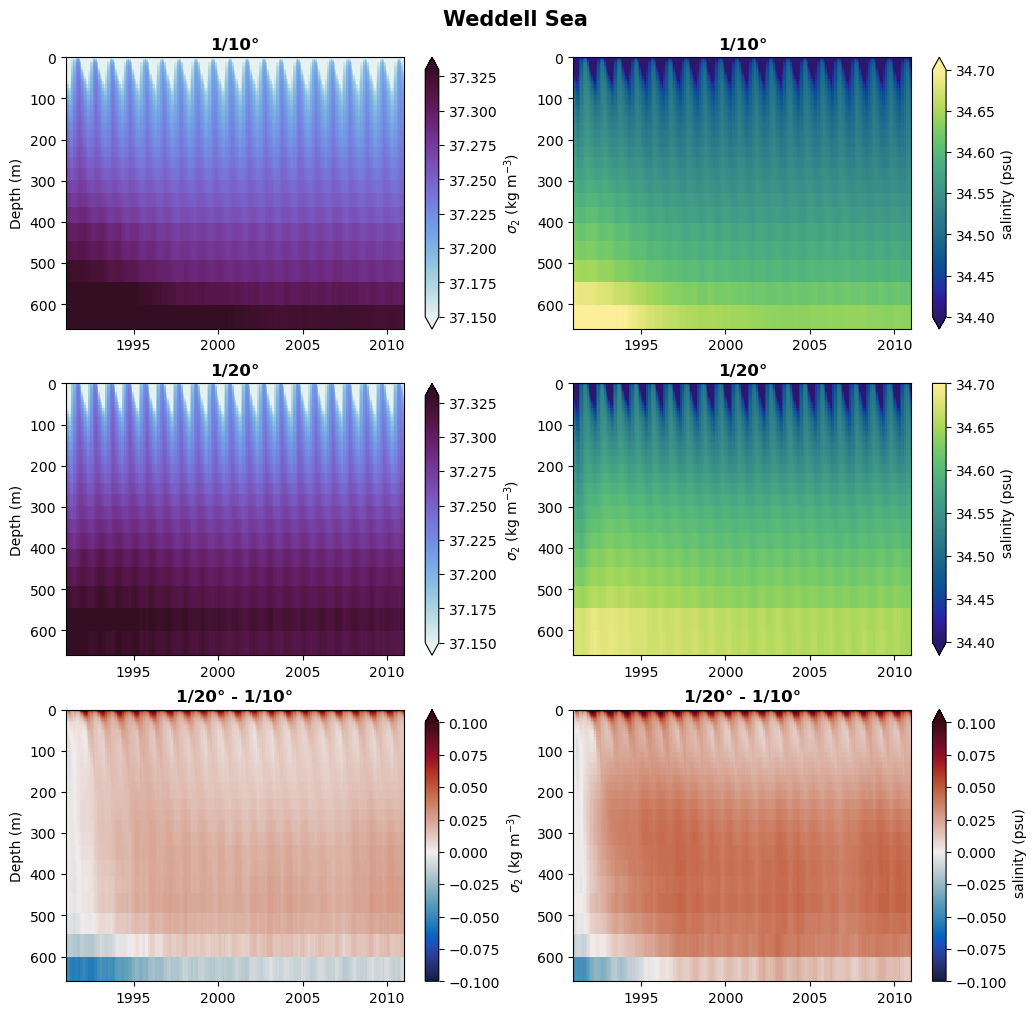

In [9]:
a = 0
plt.figure(figsize=(12, 12))
for n in range(6):
    plt.subplot(3, 2, n+1)
    if n < 4:
        var[n][a, :].transpose().plot(
            cmap=cmaps[n%2], vmin=v_min[n%2][a], vmax=v_max[n%2][a],
            cbar_kwargs={'label': cbar_label[n%2]})
    else:
        var[n][a, :].transpose().plot(
            cmap=cmo.balance, vmin=-v_max_diff[a], vmax=v_max_diff[a],
            cbar_kwargs={'label': cbar_label[n%2]})
    plt.gca().invert_yaxis()
    plt.xlabel('')
    if n%2 == 0:
        plt.ylabel('Depth (m)')
    else:
        plt.ylabel('')
    plt.title(title[np.int(np.floor(n/2))], fontweight='bold')

    if a == 0:
        plt.ylim(660, 0)


plt.suptitle(DSW_region['name_long'][a], fontweight='bold', fontsize=15, y=.92)

plt.show()

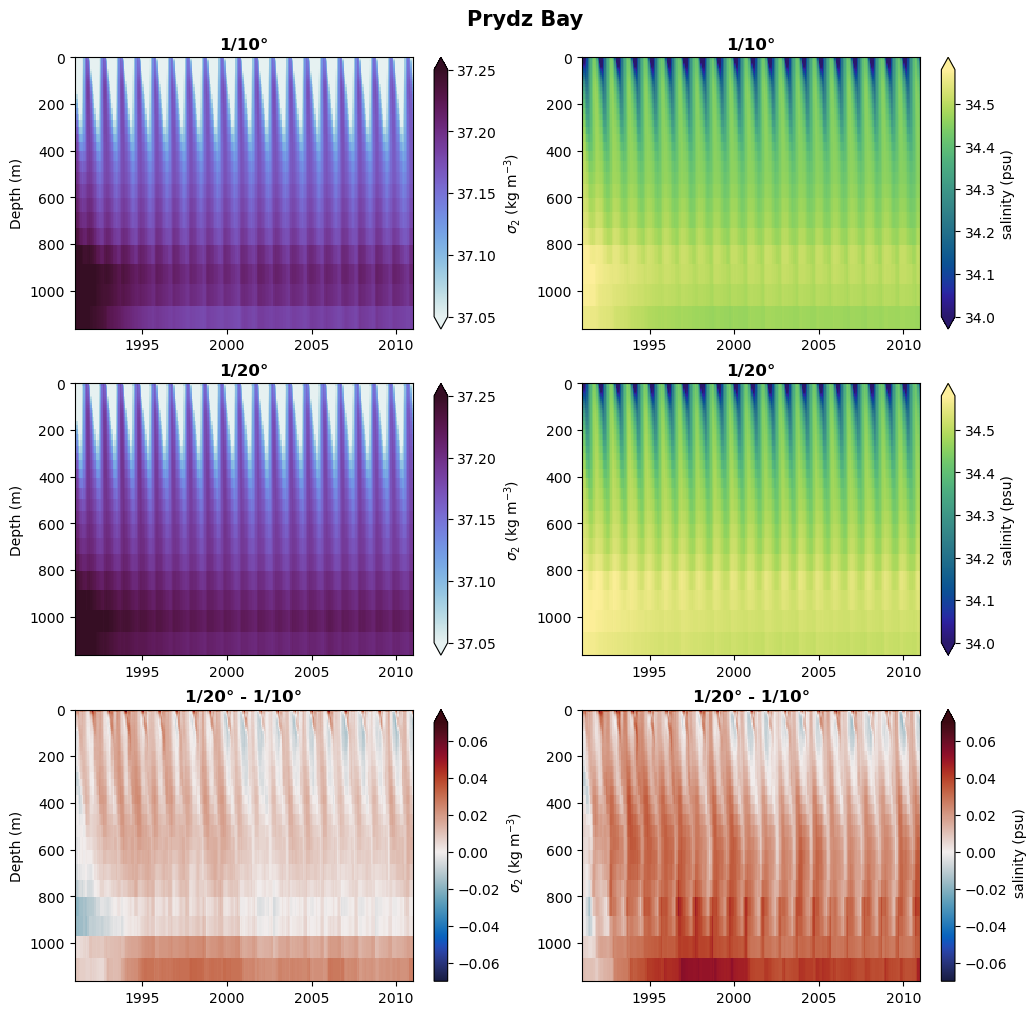

In [10]:
a = 1
plt.figure(figsize=(12, 12))
for n in range(6):
    plt.subplot(3, 2, n+1)
    if n < 4:
        var[n][a, :].transpose().plot(
            cmap=cmaps[n%2], vmin=v_min[n%2][a], vmax=v_max[n%2][a],
            cbar_kwargs={'label': cbar_label[n%2]})
    else:
        var[n][a, :].transpose().plot(
            cmap=cmo.balance, vmin=-v_max_diff[a], vmax=v_max_diff[a],
            cbar_kwargs={'label': cbar_label[n%2]})
    plt.gca().invert_yaxis()
    plt.xlabel('')
    if n%2 == 0:
        plt.ylabel('Depth (m)')
    else:
        plt.ylabel('')
    plt.title(title[np.int(np.floor(n/2))], fontweight='bold')

    if a == 0:
        plt.ylim(660, 0)


plt.suptitle(DSW_region['name_long'][a], fontweight='bold', fontsize=15, y=.92)

plt.show()

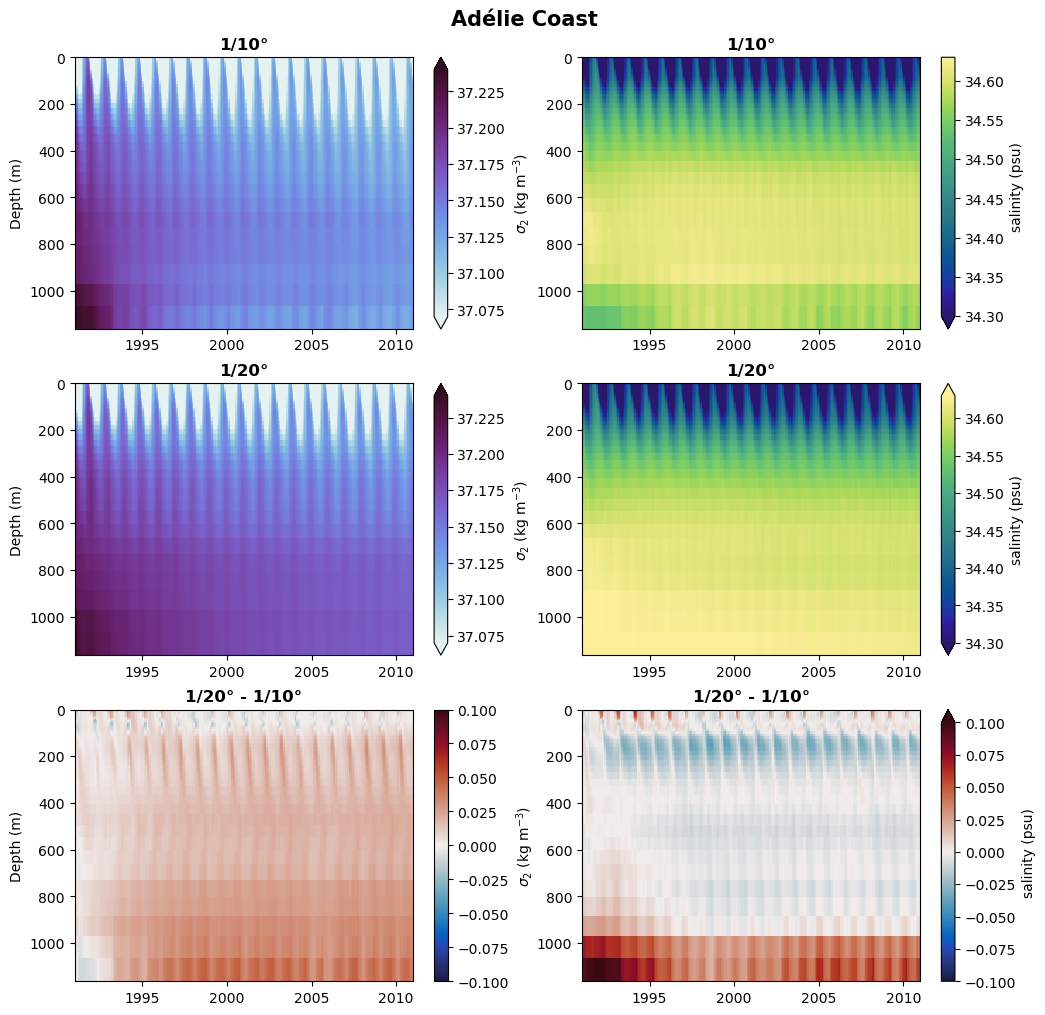

In [11]:
a = 2
plt.figure(figsize=(12, 12))
for n in range(6):
    plt.subplot(3, 2, n+1)
    if n < 4:
        var[n][a, :].transpose().plot(
            cmap=cmaps[n%2], vmin=v_min[n%2][a], vmax=v_max[n%2][a],
            cbar_kwargs={'label': cbar_label[n%2]})
    else:
        var[n][a, :].transpose().plot(
            cmap=cmo.balance, vmin=-v_max_diff[a], vmax=v_max_diff[a],
            cbar_kwargs={'label': cbar_label[n%2]})
    plt.gca().invert_yaxis()
    plt.xlabel('')
    if n%2 == 0:
        plt.ylabel('Depth (m)')
    else:
        plt.ylabel('')
    plt.title(title[np.int(np.floor(n/2))], fontweight='bold')

    if a == 0:
        plt.ylim(660, 0)


plt.suptitle(DSW_region['name_long'][a], fontweight='bold', fontsize=15, y=.92)

plt.show()

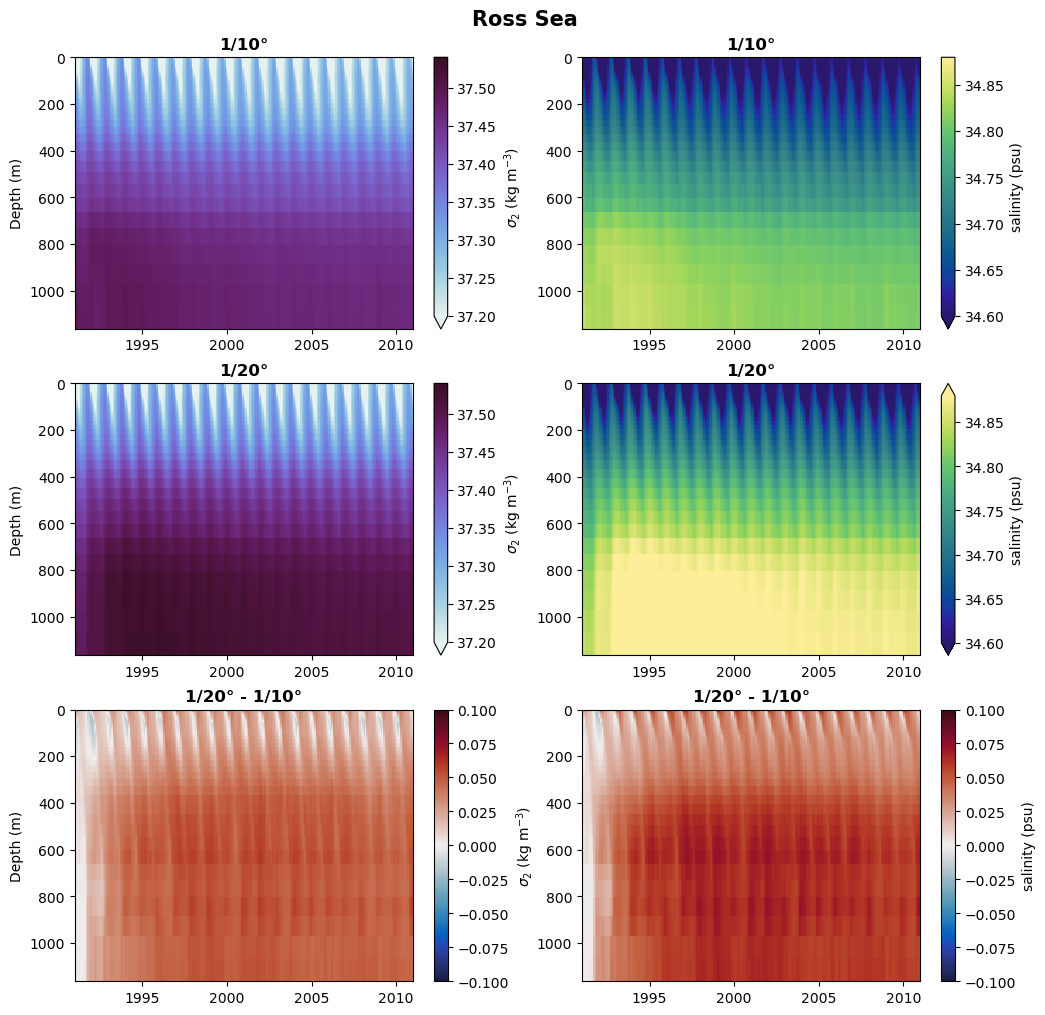

In [12]:
a = 3
plt.figure(figsize=(12, 12))
for n in range(6):
    plt.subplot(3, 2, n+1)
    if n < 4:
        var[n][a, :].transpose().plot(
            cmap=cmaps[n%2], vmin=v_min[n%2][a], vmax=v_max[n%2][a],
            cbar_kwargs={'label': cbar_label[n%2]})
    else:
        var[n][a, :].transpose().plot(
            cmap=cmo.balance, vmin=-v_max_diff[a], vmax=v_max_diff[a],
            cbar_kwargs={'label': cbar_label[n%2]})
    plt.gca().invert_yaxis()
    plt.xlabel('')
    if n%2 == 0:
        plt.ylabel('Depth (m)')
    else:
        plt.ylabel('')
    plt.title(title[np.int(np.floor(n/2))], fontweight='bold')

    if a == 0:
        plt.ylim(660, 0)


plt.suptitle(DSW_region['name_long'][a], fontweight='bold', fontsize=15, y=.92)

plt.show()